## Hatched map plot showing correlation (Pearson's p and r values) between wind speed and interpolated freeboard smoothed anomalies for full 2010-2020 period

In [1]:
import numpy as np
from scipy.stats import pearsonr
import datetime
import pandas as pd
from scipy.stats import linregress
from netCDF4 import Dataset
from scipy.interpolate import griddata
import os
import pickle
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import cartopy
import tqdm
import warnings
warnings.filterwarnings("ignore")

## CS2_CPOM

In [2]:
days = np.arange(0,4018)
dates = [datetime.date(2010,1,1)+datetime.timedelta(days=np.int(days)) for days in days]

# import snow data
snow = np.load('/Users/carmennab/PhD/OI_PolarSnow/ERA5/wind/speed_2010-2020.npy')
x_WG = np.load('/Users/carmennab/PhD/OI_PolarSnow/SnowModelLG/new_x_WG.npy') # load Will's grid, 160 x 160 array
y_WG = np.load('/Users/carmennab/PhD/OI_PolarSnow/SnowModelLG/new_y_WG.npy')

# import CS2_CPOM data
datapath = '/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_interpolated/CS2_CPOM/'
all_fbs = np.full((4018,160,160), np.nan)
for day in tqdm.tqdm(days):
    date = dates[day].strftime('%Y%m%d')
    for f in os.listdir(datapath):
        if 'FB_interp' in f:
            if date in f:
                all_fbs[day] = np.load(datapath+str(f)) 
            else: 
                pass
#np.save('/Users/carmennab/PhD/OI_PolarSnow/robbiefreebs.npy', all_fbs)

100%|██████████████████████████████████████| 4018/4018 [00:16<00:00, 245.85it/s]


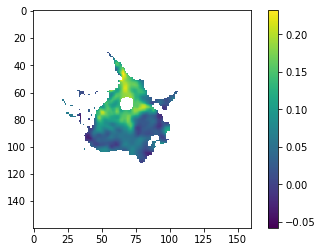

In [3]:
plt.imshow(all_fbs[300])
plt.colorbar()

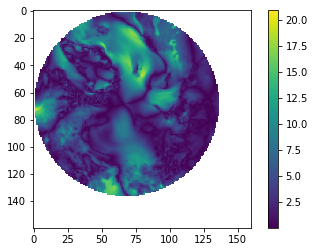

In [4]:
plt.imshow(snow[300])
plt.colorbar()

In [5]:
def regions_SM(data,regs):

    SM_mean = []

    for day in days:
        SM = data[day]
        SM_c = SM.copy()
        SM_c[~np.isin(mask, regs)] = np.nan
        SM_mean.append(np.nanmean(SM_c))
    return(SM_mean)

In [6]:
# function to calculate running mean, where T = np.int(number of days/2)

def runningmean(SM_meanss,T):
    r=[]
    for i in range(T):
        r.append(np.nanmean(SM_meanss[0:i+T+1]))

    for i in range(T,np.size(SM_meanss)-T):
        r.append(np.nanmean(SM_meanss[i-T:i+T+1]))

    for i in range(np.size(SM_meanss)-T,np.size(SM_meanss)+1):
        r.append(np.nanmean(SM_meanss[i-T:]))

    return r

In [7]:
mask = np.load('/Users/carmennab/PhD/OI_PolarSnow/mask_values.npy')

Kara
-0.0001386513160901801


<Figure size 432x288 with 0 Axes>

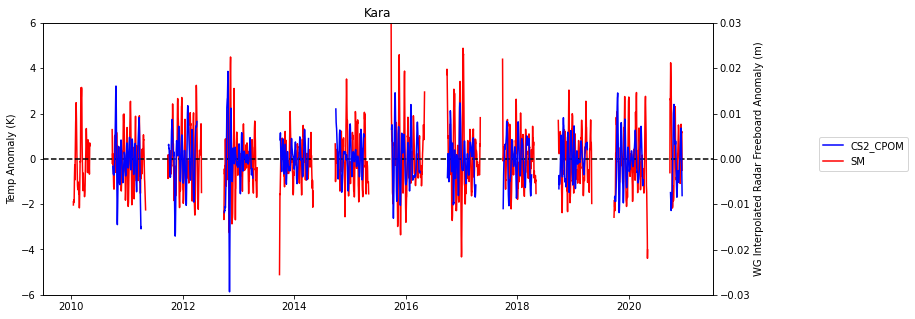

Laptev
9.205014123372372e-05


<Figure size 432x288 with 0 Axes>

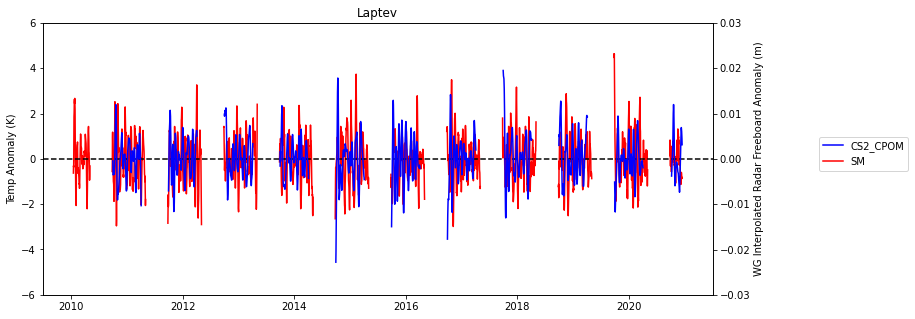

E. Siberian
-3.085612380462094e-05


<Figure size 432x288 with 0 Axes>

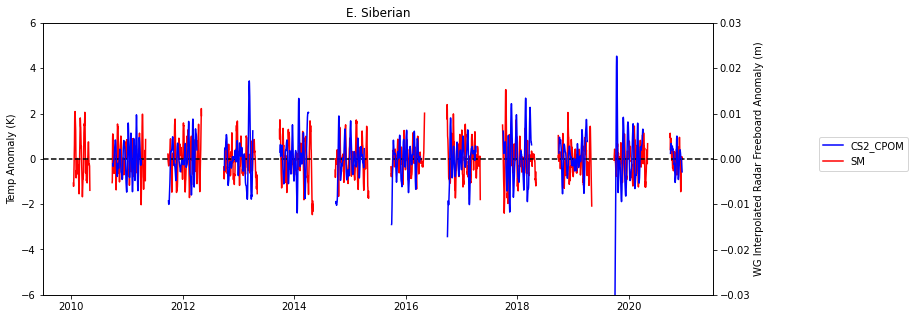

Chukchi
-3.977022412010695e-05


<Figure size 432x288 with 0 Axes>

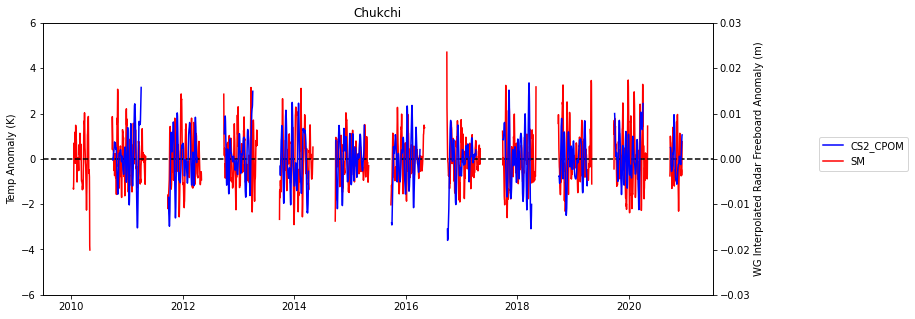

 Beaufort
-0.00017734839925015791


<Figure size 432x288 with 0 Axes>

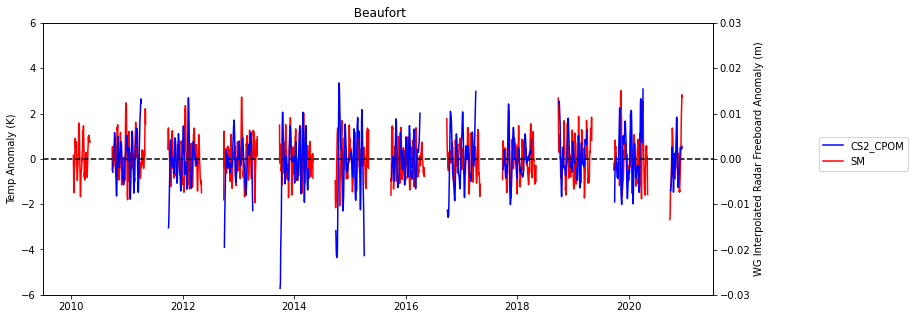

Can. Arch
0.00015067343350613877


<Figure size 432x288 with 0 Axes>

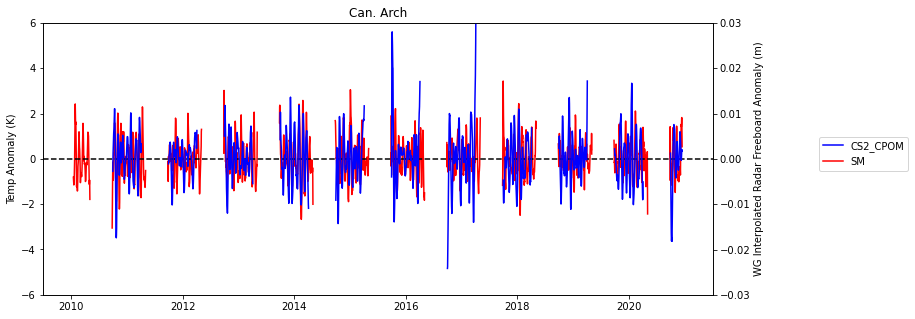

Central Arctic
-0.0004271101757183845


<Figure size 432x288 with 0 Axes>

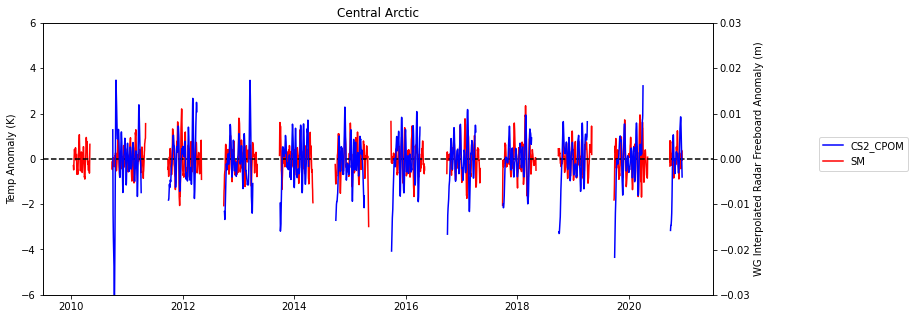

In [8]:
# we take a 30-day running mean of freeboard, then subtract this from the daily freeboards, then take a 9-day running mean of this. 
rm1 = 15
rm2 = 4

temps = {}
freebs = {}

for regs, reg_name in zip([[9], [10], [11], [12], [13], [14], [15]], 
                          ['Kara', 'Laptev', 'E. Siberian', 'Chukchi',' Beaufort', 'Can. Arch', 'Central Arctic']):

    
    SM_means = regions_SM(data=snow,regs=regs)
    CS2_CPOM_means = regions_SM(data = all_fbs,regs=regs)

    SM_smooth = runningmean(SM_means,T=15)
    CS2_CPOM_smooth = runningmean(CS2_CPOM_means,T=15)
    
    
    SM_anom = runningmean(np.asarray(SM_means) - np.asarray(SM_smooth[:-1]), T=4)
    CS2_CPOM_anom = runningmean(np.asarray(CS2_CPOM_means) - np.asarray(CS2_CPOM_smooth[:-1]), T=4)
    
    print(reg_name)
    print(np.nanmean(CS2_CPOM_anom))
    
    
    temps[reg_name]=SM_anom
    freebs[reg_name]=CS2_CPOM_anom

    plt.figure()
    fig, (ax1) = plt.subplots(1,1,figsize=(12,5))

    ax1.plot(dates[(rm1):-(rm1)],SM_anom[(rm1):-(rm1)][:-1],color='r')
    ax1.set_ylabel('Temp Anomaly (K)',color='k')
    ax1.set_ylim(-6,6)
    ax1b = ax1.twinx()
    ax1b.set_ylim(-0.03,0.03)
    ax1b.plot(dates[(rm1):-(rm1)],CS2_CPOM_anom[(rm1):-(rm1)][:-1],label='CS2_CPOM',color='b')
    ax1b.plot([dates[40]],[0],color='r',label='SM')
    ax1b.set_ylabel('WG Interpolated Radar Freeboard Anomaly (m)',color='k')

    ax1.axhline(0,color='k',ls='--')
    plt.legend(bbox_to_anchor = (1.30, 0.6))    
    ax1.set_title(reg_name)

    plt.show()



In [9]:
regions = ['Kara', 'Laptev', 'E. Siberian', 'Chukchi',' Beaufort', 'Can. Arch', 'Central Arctic']

for region in regions:
    t = np.asarray(temps[region])[:-1]
    f = np.asarray(freebs[region])[:-1]
    mask = ~np.isnan(t[:]) & ~np.isnan(f[:])
    if np.count_nonzero(np.nan_to_num(mask)) > 2: # if more than 2 days in snow and freeb have data then continue
        
        rstats = linregress(t[:][mask],f[mask]) # correlate valid snow and freeb for each grid cell 
        s = rstats.slope
        r = rstats.rvalue
        p = rstats.pvalue
        
    print(region , ' r = ' , r ,  ' p = ' , p , ' slope = ' , s)

Kara  r =  0.14676474035330028  p =  6.48435616108107e-11  slope =  0.0006170659348025175
Laptev  r =  0.09832359392798903  p =  1.3295092082553893e-05  slope =  0.00047190644971344646
E. Siberian  r =  -0.013792452009300963  p =  0.5414849239091112  slope =  -9.770661367439567e-05
Chukchi  r =  0.02884786040508511  p =  0.20151324462573744  slope =  0.00015298963303124653
 Beaufort  r =  0.15307253030900891  p =  9.351189509241068e-12  slope =  0.0010178124013199418
Can. Arch  r =  0.2731438515024274  p =  6.5476929740603e-35  slope =  0.0019242237058963165
Central Arctic  r =  0.3134976081669575  p =  5.338618033223611e-46  slope =  0.0026894704259224932


# plot all seasons in one

In [10]:
# do smooth anoms for each grid cell

T1 = 15 ## for 30-day running mean put T=15
T2 = 4 ## for 9-day running mean of anomalies put T=4

freeb_anoms_big = np.full(snow.shape,np.nan)
snows_anoms_big = np.full(snow.shape,np.nan)

for day in tqdm.trange(snow.shape[0]):
    
    # each day, make the 30 day running mean (15 either side)
    
    snows_30day = np.nanmean(snow[day-T1:day+T1],axis=0) # 30-day running mean for each grid cell in time dimension
    freeb_30day = np.nanmean(all_fbs[day-T1:day+T1],axis=0)
    
    # now make anomalies from 30 day means
    
    snows_anoms_big[day] = snow[day] - snows_30day 
    freeb_anoms_big[day] = all_fbs[day] - freeb_30day
    

# the following for loop can actually be removed by taking the running mean with convolve
# RDCM has done this before, you have to convolve along an axis of a 3d numpy array using a special module

fb_running_mean_anoms = np.full(snow.shape,np.nan)
sd_running_mean_anoms = np.full(snow.shape,np.nan)
# 9 day mean of anoms for each grid cell in time dimension
for day in tqdm.trange(snow.shape[0]):
    
        fb_running_mean_anoms[day] = np.nanmean(freeb_anoms_big[day-T2:day+T2],axis=0) 
        sd_running_mean_anoms[day] = np.nanmean(snows_anoms_big[day-T2:day+T2],axis=0)

100%|██████████████████████████████████████| 4018/4018 [00:04<00:00, 962.99it/s]


In [11]:
# pickle.dump((fb_running_mean_anoms,sd_running_mean_anoms),open('cache1.p','wb')) # cache data so far so if kernel breaks we're safe
                                                               
# (fb_running_mean_anoms,sd_running_mean_anoms) = pickle.load(open('cache1.p','rb'))

In [12]:
ps = np.full((160,160), np.nan)
rs = np.full((160,160), np.nan)
n_valid = np.full((160,160), np.nan)

for i, j in tqdm.tqdm(itertools.product(np.arange(160),
                              np.arange(160))):
    # calculate p and r for full timeseries per grid cell
    
    mask = ~np.isnan(fb_running_mean_anoms[:,i,j]) & ~np.isnan(sd_running_mean_anoms[:,i,j]) # mask out cells with nan snow or nan freeb
    
    if np.count_nonzero(np.nan_to_num(mask)) > 2: # if more than 2 days in snow and freeb have data then continue
        
            
        rstats = pearsonr(fb_running_mean_anoms[:,i,j][mask],sd_running_mean_anoms[:,i,j][mask]) # correlate valid snow and freeb for each grid cell 
        r = np.round(rstats[0],decimals=2)
        p = np.round(rstats[1],decimals=3)
        ps[i,j] = p
        rs[i,j] = r
        n_valid[i,j] = len(mask[mask]) # number of valid days in time series - where mask is true 

25600it [00:03, 8154.08it/s] 


In [13]:
ps = np.full((160,160), np.nan)
rs = np.full((160,160), np.nan)
ss = np.full((160,160), np.nan)
n_valid = np.full((160,160), np.nan)

for i, j in tqdm.tqdm(itertools.product(np.arange(160),
                              np.arange(160))):
    # calculate p and r for full timeseries per grid cell
    
    mask = ~np.isnan(fb_running_mean_anoms[:,i,j]) & ~np.isnan(sd_running_mean_anoms[:,i,j]) # mask out cells with nan snow or nan freeb
    
    if np.count_nonzero(np.nan_to_num(mask)) > 2: # if more than 2 days in snow and freeb have data then continue
        
            
        rstats = linregress(sd_running_mean_anoms[:,i,j][mask],fb_running_mean_anoms[:,i,j][mask]) # correlate valid snow and freeb for each grid cell 
        s = rstats.slope
        r = rstats.rvalue
        p = rstats.pvalue
        ss[i,j] = s
        ps[i,j] = p
        rs[i,j] = r
        n_valid[i,j] = len(mask[mask]) # number of valid days in time series - where mask is true 

25600it [00:01, 13010.29it/s]


Text(0.5, 0, 'Grey areas are where p>0.05')

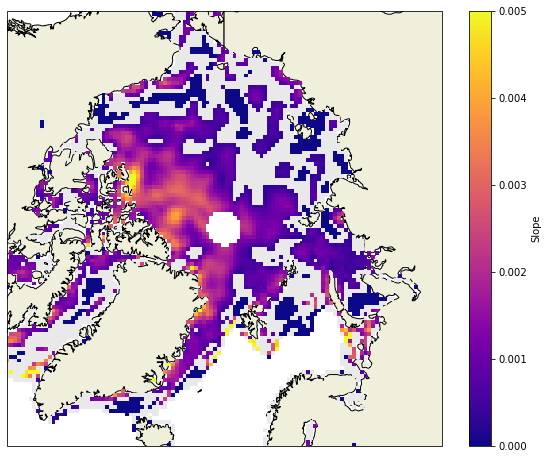

In [14]:
# cartopy

lats = np.load('/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed/Robbie_lat.npy')
lons = np.load('/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed/Robbie_lon.npy')

ss[ps>0.05] = 1000
grey = ss.copy()
grey[grey <1000] = np.nan
ss[rs==1000] = np.nan

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)
ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
p_map = ax.pcolormesh(lons,lats,ss,cmap='plasma',
                      vmin=0,vmax=0.005,
                      alpha=1.0, transform=ccrs.PlateCarree())
ax.pcolormesh(lons,lats,grey,cmap='Greys',vmin=0,vmax=6000,alpha=1.0, transform=ccrs.PlateCarree())
a = fig.colorbar(p_map)
a.set_label('Slope')
# ax.set_title('Correlation between SM-LG and CS2_CPOM interpolated freeboards smoothed anomalies for full 2010-2020 period',fontsize='x-large', pad=20)
ax.set_xlabel('Grey areas are where p>0.05')
# plt.savefig('/Users/carmennab/Dropbox/Apps/Overleaf/AGU GRL Snow Interpolated Freeboards/figures/regional_wind_slope.png',bbox_inches = "tight")

4018


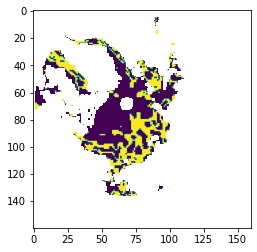

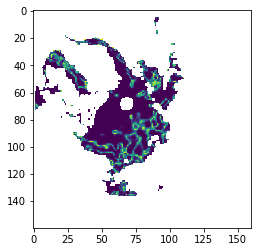

In [16]:
# plt.plot(fb_running_mean_anoms)
# plt.show(sd_running_mean_anoms)
print(snow.shape[0])
plt.imshow(ss)
plt.show()
plt.imshow(ps)
plt.show()